In [1]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Useful function for later
def load_image(url, size=None):
    response = requests.get(url,timeout=0.2)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

device = "cuda:2" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

/opt/conda/envs/tango/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [2]:
@torch.no_grad()
def sample(prompt, start_step=0, start_latents=None,
           guidance_scale=3.5, num_inference_steps=30,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):
  
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    # for i in tqdm(range(start_step, num_inference_steps)):
    for i in range(start_step, num_inference_steps):

        t = pipe.scheduler.timesteps[i]
        print(t.item(), end='/ ')

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)


        # Normally we'd rely on the scheduler to handle the update step:
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # Instead, let's do it ourselves:
        prev_t = max(1, t.item() - (1000//num_inference_steps)) # t-1
        print('p: ', t.item() - (1000//num_inference_steps), end='/ ')
        alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
        print('c: ', t.item())
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        predicted_x0 = (latents - (1-alpha_t).sqrt()*noise_pred) / alpha_t.sqrt()
        direction_pointing_to_xt = (1-alpha_t_prev).sqrt()*noise_pred
        latents = alpha_t_prev.sqrt()*predicted_x0 + direction_pointing_to_xt

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

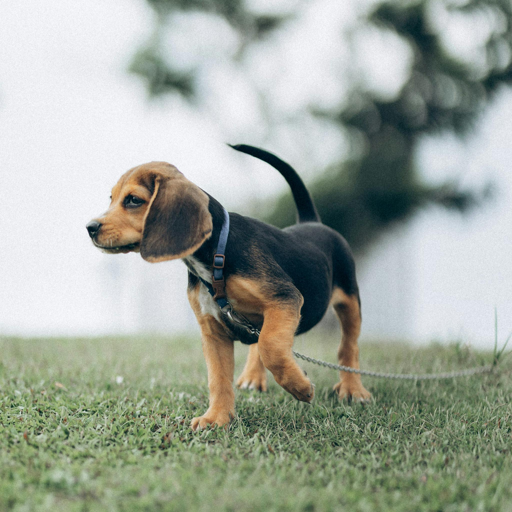

In [3]:
input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
input_image_prompt = "Photograph of a puppy on the grass"
input_image

In [4]:
# Encode with VAE
with torch.no_grad(): 
  latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1)
l = 0.18215 * latent.latent_dist.sample()

In [5]:
## Inversion
@torch.no_grad()
def invert(start_latents, prompt, guidance_scale=3.5, num_inference_steps=80,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):
    pipe.to(device)
    # Encode prompt
    text_embeddings = pipe._encode_prompt(
            prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps <<<<<<<<<<<<<<<<<<<<
    timesteps = reversed(pipe.scheduler.timesteps)

    # for i in tqdm(range(1, num_inference_steps), total=num_inference_steps-1):
    for i in range(1, num_inference_steps):

        # We'll skip the final iteration
        if i >= num_inference_steps - 1: continue

        t = timesteps[i]
        print(t.item(), end='/ ')

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        current_t = max(0, t.item() - (1000//num_inference_steps)) #t
        print('c', current_t, end='/ ')
        next_t = t # min(999, t.item() + (1000//num_inference_steps)) # t+1
        print('n', next_t.item())
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1-alpha_t).sqrt()*noise_pred)*(alpha_t_next.sqrt()/alpha_t.sqrt()) + (1-alpha_t_next).sqrt()*noise_pred

        # Store
        intermediate_latents.append(latents)
            
    return torch.cat(intermediate_latents)

In [6]:
inverted_latents = invert(l, input_image_prompt, num_inference_steps=50,)
inverted_latents.shape

21/ c 1/ n 21
41/ c 21/ n 41
61/ c 41/ n 61
81/ c 61/ n 81
101/ c 81/ n 101
121/ c 101/ n 121
141/ c 121/ n 141
161/ c 141/ n 161
181/ c 161/ n 181
201/ c 181/ n 201
221/ c 201/ n 221
241/ c 221/ n 241
261/ c 241/ n 261
281/ c 261/ n 281
301/ c 281/ n 301
321/ c 301/ n 321
341/ c 321/ n 341
361/ c 341/ n 361
381/ c 361/ n 381
401/ c 381/ n 401
421/ c 401/ n 421
441/ c 421/ n 441
461/ c 441/ n 461
481/ c 461/ n 481
501/ c 481/ n 501
521/ c 501/ n 521
541/ c 521/ n 541
561/ c 541/ n 561
581/ c 561/ n 581
601/ c 581/ n 601
621/ c 601/ n 621
641/ c 621/ n 641
661/ c 641/ n 661
681/ c 661/ n 681
701/ c 681/ n 701
721/ c 701/ n 721
741/ c 721/ n 741
761/ c 741/ n 761
781/ c 761/ n 781
801/ c 781/ n 801
821/ c 801/ n 821
841/ c 821/ n 841
861/ c 841/ n 861
881/ c 861/ n 881
901/ c 881/ n 901
921/ c 901/ n 921
941/ c 921/ n 941
961/ c 941/ n 961


torch.Size([48, 4, 64, 64])

/opt/conda/envs/tango/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:471: FutureWarning: The decode_latents method is deprecated and will be removed in a future version. Please use VaeImageProcessor instead
  warnings.warn(


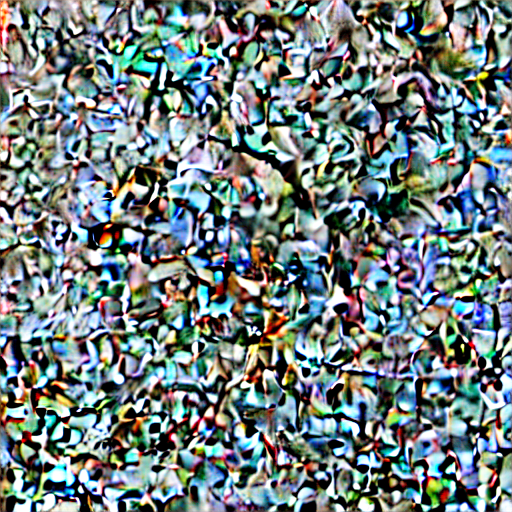

In [7]:
with torch.no_grad():
  im = pipe.decode_latents(inverted_latents[-1].unsqueeze(0))
pipe.numpy_to_pil(im)[0]

821/ 

p:  801/ c:  821
801/ p:  781/ c:  801
781/ p:  761/ c:  781
761/ p:  741/ c:  761
741/ p:  721/ c:  741
721/ p:  701/ c:  721
701/ p:  681/ c:  701
681/ p:  661/ c:  681
661/ p:  641/ c:  661
641/ p:  621/ c:  641
621/ p:  601/ c:  621
601/ p:  581/ c:  601
581/ p:  561/ c:  581
561/ p:  541/ c:  561
541/ p:  521/ c:  541
521/ p:  501/ c:  521
501/ p:  481/ c:  501
481/ p:  461/ c:  481
461/ p:  441/ c:  461
441/ p:  421/ c:  441
421/ p:  401/ c:  421
401/ p:  381/ c:  401
381/ p:  361/ c:  381
361/ p:  341/ c:  361
341/ p:  321/ c:  341
321/ p:  301/ c:  321
301/ p:  281/ c:  301
281/ p:  261/ c:  281
261/ p:  241/ c:  261
241/ p:  221/ c:  241
221/ p:  201/ c:  221
201/ p:  181/ c:  201
181/ p:  161/ c:  181
161/ p:  141/ c:  161
141/ p:  121/ c:  141
121/ p:  101/ c:  121
101/ p:  81/ c:  101
81/ p:  61/ c:  81
61/ p:  41/ c:  61
41/ p:  21/ c:  41
21/ p:  1/ c:  21
1/ p:  -19/ c:  1


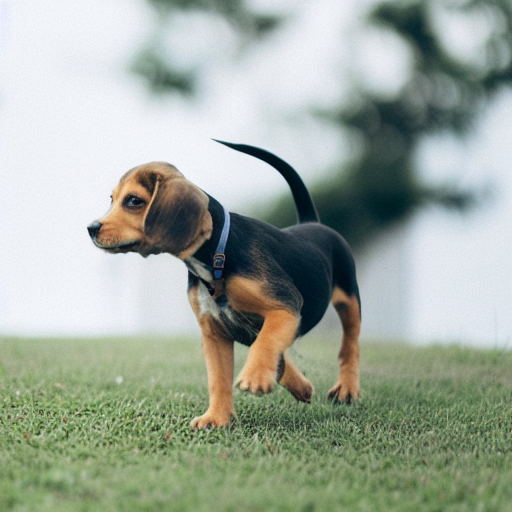

In [ ]:
# The reason we want to be able to specify start step
start_step = 8
# sample(input_image_prompt, start_latents=inverted_latents[-(start_step+1)][None], 
#        start_step=start_step, num_inference_steps=50)[0]
sample(input_image_prompt, start_latents=inverted_latents[-(start_step+1)][None], 
       start_step=start_step, num_inference_steps=50)[0]

Photograph of a cat on the grass
981/ p:  961/ c:  981
961/ p:  941/ c:  961
941/ p:  921/ c:  941
921/ p:  901/ c:  921
901/ p:  881/ c:  901
881/ p:  861/ c:  881
861/ p:  841/ c:  861
841/ p:  821/ c:  841
821/ p:  801/ c:  821
801/ p:  781/ c:  801
781/ p:  761/ c:  781
761/ p:  741/ c:  761
741/ p:  721/ c:  741
721/ p:  701/ c:  721
701/ p:  681/ c:  701
681/ p:  661/ c:  681
661/ p:  641/ c:  661
641/ p:  621/ c:  641
621/ p:  601/ c:  621
601/ p:  581/ c:  601
581/ p:  561/ c:  581
561/ p:  541/ c:  561
541/ p:  521/ c:  541
521/ p:  501/ c:  521
501/ p:  481/ c:  501
481/ p:  461/ c:  481
461/ p:  441/ c:  461
441/ p:  421/ c:  441
421/ p:  401/ c:  421
401/ p:  381/ c:  401
381/ p:  361/ c:  381
361/ p:  341/ c:  361
341/ p:  321/ c:  341
321/ p:  301/ c:  321
301/ p:  281/ c:  301
281/ p:  261/ c:  281
261/ p:  241/ c:  261
241/ p:  221/ c:  241
221/ p:  201/ c:  221
201/ p:  181/ c:  201
181/ p:  161/ c:  181
161/ p:  141/ c:  161
141/ p:  121/ c:  141
121/ p:  101/ c:  121

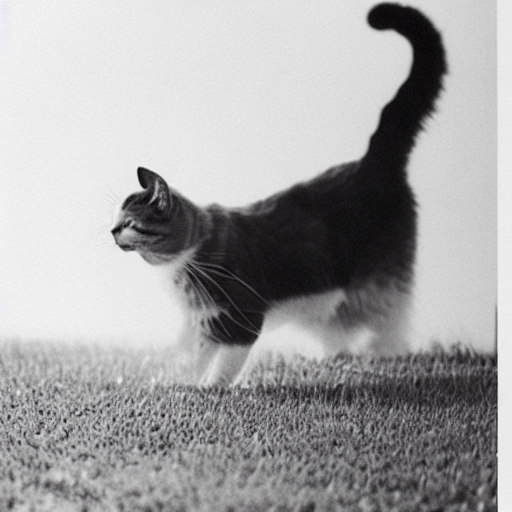

In [9]:
start_step = 0
new_prompt = input_image_prompt.replace('puppy', 'cat')
print(new_prompt)
sample(new_prompt, start_latents=inverted_latents[-(start_step+1)][None], 
       start_step=start_step, num_inference_steps=50)[0]

In [ ]:
def edit(input_image, input_image_prompt, edit_prompt, num_steps=100, start_step=30, guidance_scale=3.5):
    with torch.no_grad(): 
        latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1)
    l = 0.18215 * latent.latent_dist.sample()
    inverted_latents = invert(l, input_image_prompt, num_inference_steps=num_steps)
    final_im = sample(edit_prompt, start_latents=inverted_latents[-(start_step+1)][None], 
                      start_step=start_step, num_inference_steps=num_steps, guidance_scale=guidance_scale)[0]
    return final_im